In [3]:
# CREA LOS PLANOS DE MADURACION PARA COSECHA

In [1]:
# IMPORTACIONES
import sys
sys.path.append('..')
from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE

import os
import geopandas as gpd
import pandas as pd
import re
from collections import namedtuple
import unicodedata
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
from matplotlib.patches import Patch
from docx.shared import Mm

import docxtpl
from docxtpl import DocxTemplate

In [2]:
RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

#path_tif = r"C:\Users\bismarksr\Downloads\SENTINEL_2025-02-12_UTM_2.tif"
path_tif = r"C:\Users\Usuario\Downloads\SENTINEL_2025-02-12_UTM.tif"
# Cargar la imagen TIFF con rasterio
with rasterio.open(path_tif) as src:
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]  # Límites geoespaciales
    img = src.read([1, 2, 3])  # Leer las bandas RGB

In [6]:
def generar_plano_os(shp_prop, path_tif, path_out):
    colores_orden = {
        1: '#FF0000',  # Rojo
        2: '#FF4500',  # Naranja fuerte
        3: '#FFA500',  # Naranja
        4: '#FFB733',  # Naranja claro
        5: '#FFD700',  # Amarillo fuerte
        6: '#FFFF00',  # Amarillo
        7: '#CCFF00',  # Verde lima claro
        8: '#99CC00',  # Verde lima medio
        9: '#669900',  # Verde pasto
        10: '#336600', # Verde oliva oscuro
        11: '#006600', # Verde oscuro
    }
    leyenda_textos = {
        1: 'Lotes Maduros (iniciar cosecha)',
        2: '',
        3: '',
        4: '',
        5: '',
        6: 'Madurez intermedia',
        7: '',
        8: '',
        9: '',
        10: '',
        11: 'Lotes con maduracion baja'
    }
    shp_prop = shp_prop.copy()
    shp_prop['color'] = shp_prop['orden'].map(colores_orden)
    
    # Crear el plano
    fig, ax = plt.subplots(figsize=(15, 15))
    # Mostrar la imagen de fondo (TIFF) con coordenadas georreferenciadas
    show(img, transform=src.transform, ax=ax)
    #facecolor=(R, G, B, Alpha)
    shp_prop.plot(ax=ax, edgecolor='black', facecolor=shp_prop['color'], linewidth=1)
    
    # Agregar etiquetas con lote mas area
    for idx, row in shp_prop.iterrows():
        if row.geometry is not None:
            label = f"{row['unidad_05']}\n{round(row['area'], 2)} ha"
            centroid = row.geometry.representative_point()  # Mejor que .centroid en algunos casos
            ax.text(centroid.x, centroid.y, label, fontsize=7, ha='center', color='black', weight=1000,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.2, pad=0))
    
    # Configurar título
    nom_prop = shp_prop["unidad_02"].iloc[0]
    ax.set_title(nom_prop, fontsize=14)

    # 🔍 **Ajustar los límites del mapa para hacer zoom en la propiedad**
    bounds = shp_prop.total_bounds  # [xmin, ymin, xmax, ymax]
    ax.set_xlim([bounds[0] - 400, bounds[2] + 400])
    ax.set_ylim([bounds[1] - 400, bounds[3] + 400])
    
    # Leyenda dinámica para colores por orden
    legend_colores = [
        Patch(facecolor=colores_orden[orden], edgecolor='black', label=leyenda_textos[orden])
        for orden in colores_orden
    ]
    # Mostrar la leyenda
    ax.legend(handles=legend_colores, loc='upper right', fontsize=9,
              frameon=True, facecolor='white', edgecolor='black')
    out = os.path.join(path_out, str(shp_prop["unidad_02"].iloc[0]) + '.jpg')
    # Guardar plano
    fig.savefig(path_out, dpi = 300, bbox_inches='tight')
    
    # Mostrar el mapa
    #plt.show()

In [7]:
# Ruta completa al archivo .shp (cambia el nombre del archivo por el que necesitas)
ruta_shp =  RUTA_UNIDAD_ONE_DRIVE + r"\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - AVANCE COSECHA\2025\MADURACION\SHP\LOTES_MADURACION.shp"
# Cargar shapefile
gdf_cat = gpd.read_file(ruta_shp)
gdf_cat = gdf_cat[['unidad_01', 'unidad_02','unidad_03', 'unidad_04', 'unidad_05', 'area', 'orden', 'geometry']]

In [8]:
# Ruta completa de grupos
ruta_grupos =  RUTA_UNIDAD_ONE_DRIVE + r"\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - AVANCE COSECHA\2025\DATA\GRUPO_COSECHA.xlsx"
# Cargar datos
df_grupos = pd.read_excel(ruta_grupos, sheet_name = 'CODIGOS')
df_grupos.head(3)

,CODIGO CAÑERO,NOMBRE CAÑERO,GRUPO DE COSECHA,INSTITUCION,DELEGADO,obs
0,515,AGUILERA OLGA RIVERO VDA DE,1,50.0,DELEGADO,515.0
1,1215,AGUILERA RIVERO OLGA KARINA,1,50.0,NaN,1215.0
2,8003,AGUILERA RIVERO SERGIO STEFAN,1,50.0,NaN,8003.0


In [9]:
# Ruta completa de grupos
ruta_grupos =  RUTA_UNIDAD_ONE_DRIVE + r"\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - AVANCE COSECHA\2025\DATA\GRUPO_COSECHA.xlsx"
# Cargar datos
df_grupos = pd.read_excel(ruta_grupos, sheet_name = 'CODIGOS')

#Limpiar nombres de columnas
def limpiar_nombre(col):
    col = col.strip().lower()
    col = unicodedata.normalize('NFKD', col).encode('ascii', 'ignore').decode('utf-8')  # elimina tildes y ñ
    col = re.sub(r'\W+', '_', col)  # reemplaza cualquier no-alfanumérico por _
    return col

df_grupos.columns = [limpiar_nombre(col) for col in df_grupos.columns]

In [10]:
df_grupos

,codigo_canero,nombre_canero,grupo_de_cosecha,institucion,delegado,obs
0,515,AGUILERA OLGA RIVERO VDA DE,1,50.0,DELEGADO,515.0
1,1215,AGUILERA RIVERO OLGA KARINA,1,50.0,NaN,1215.0
2,8003,AGUILERA RIVERO SERGIO STEFAN,1,50.0,NaN,8003.0
3,40004,AGUILERA RIVERO NICOLAS JULIO,1,50.0,NaN,40004.0
4,42163,GARCIA PELLEGRINI LUIS FERNANDO,1,62.0,NaN,42163.0
...,...,...,...,...,...,...
1412,42436,CHAMBI RODRIGUEZ DORYS,630,NaN,DELEGADO,NaN
1413,4942,GUZMAN ORELLANA JHONN A.,632,304.0,DELEGADO,4942.0
1414,30843,ORELLANA DAVILA MAGALI,632,304.0,NaN,30843.0
1415,40138,MAMANI MAMANI IRMA,631,18.0,DELEGADO,40138.0


In [42]:
cod_grupo= 385
grupo = df_grupos[df_grupos['grupo_de_cosecha'] == cod_grupo]

# Convertir cada fila a namedtuple usando .to_dict()
grupo_obj = []
for _, row in grupo.iterrows():
    fila_dict = row.to_dict()
    Tupla = namedtuple("grupo", fila_dict.keys())
    objeto = Tupla(*fila_dict.values())
    grupo_obj.append(objeto)

cods_ca = list(set(grupo['codigo_canero']))

df_filtrado = gdf_cat[gdf_cat['unidad_03'].isin(cods_ca)]
cods_prop = list(set(df_filtrado['unidad_01']))
props = [int(i) for i in cods_prop]
props

[1512, 4]

In [43]:
grupo

,codigo_canero,nombre_canero,grupo_de_cosecha,institucion,delegado,obs
1028,1843,CATALA ABREGO SEGISMUNDO,385,62.0,NaN,1843.0
1029,41826,CATALA VACA LOY LUIS,385,62.0,DELEGADO,41826.0


G:\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\planos\1512_FITO JUSTINIANO--CATALA.jpg
1512
G:\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\planos\4_SAN JORGE--CATALA.jpg
4


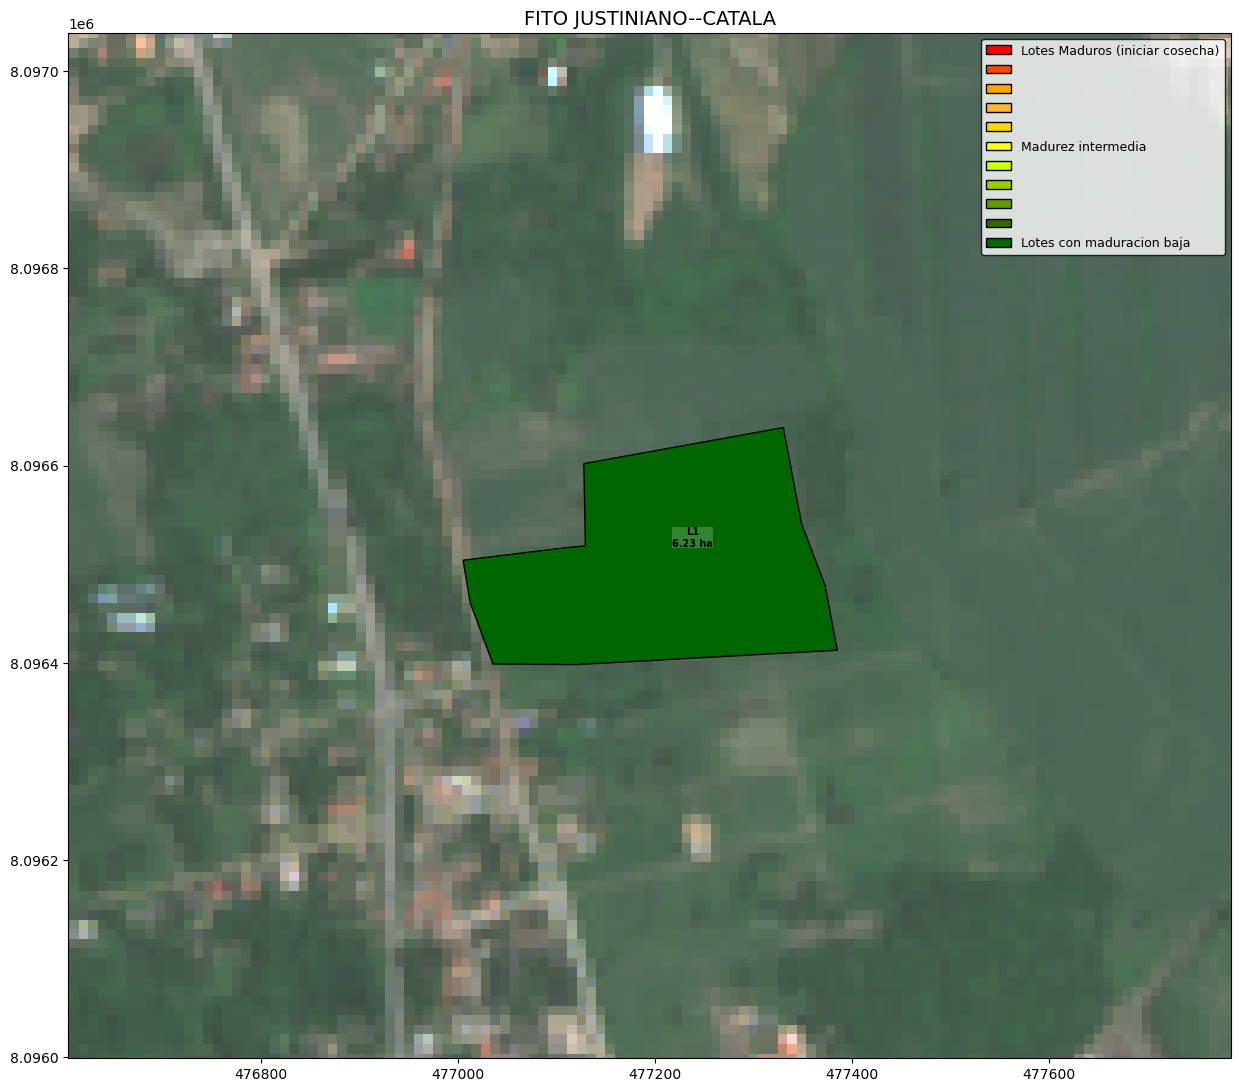

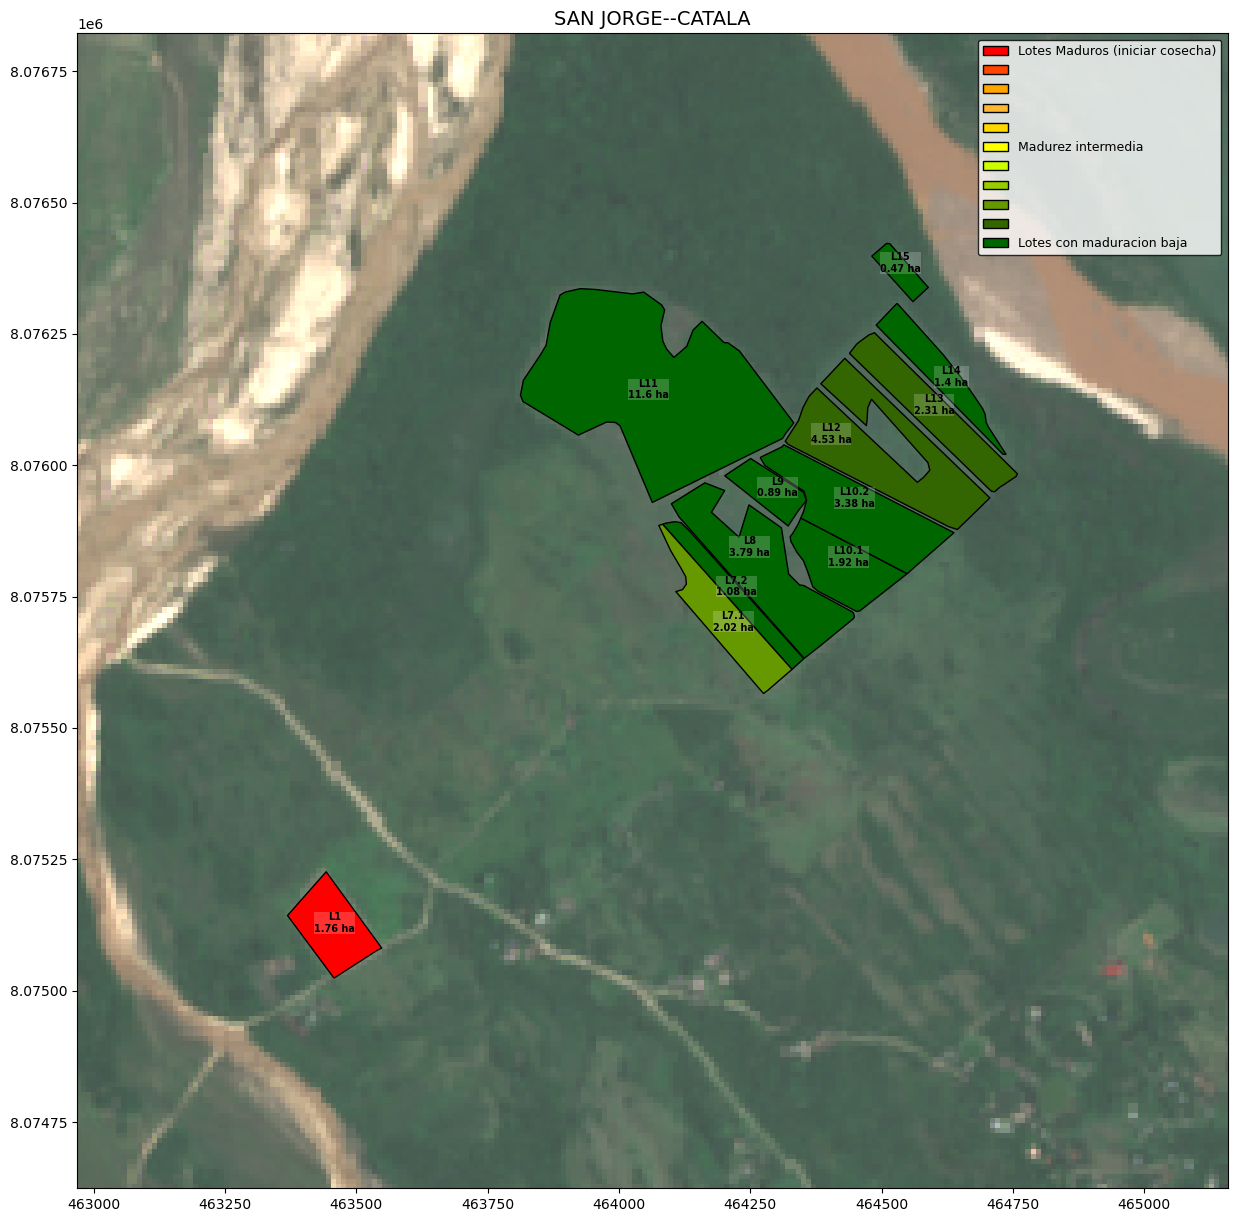

In [44]:
rutas_planos = []
for i in props:
    prop = gdf_cat[gdf_cat['unidad_01'] == i]
    prop = prop.copy()
    # Obtener los valores de unidad_01 y unidad_02
    prop['unidad_01'] = prop['unidad_01'].astype(int)
    unidad_01 = prop['unidad_01'].iloc[0]
    unidad_02 = prop['unidad_02'].iloc[0]
    # Crear el nombre del archivo concatenando unidad_01 y unidad_02
    nombre_archivo = f'{unidad_01}_{unidad_02}'
    path_plano = os.path.join(RUTA_COMPLETA, "planos", nombre_archivo + '.jpg')
    print(path_plano)
    generar_plano_os(prop, path_tif, path_plano)
    rutas_planos.append(path_plano)
    print(i)

In [45]:
doc = DocxTemplate(RUTA_COMPLETA + "/templates/tpl_rpt_maduracion.docx")
lista_InlineImage = []
for plano in rutas_planos:
    lista_InlineImage.append(docxtpl.InlineImage(doc, image_descriptor=plano, width=Mm(150)))

context = {'grupo':grupo_obj, 'planos':lista_InlineImage}
doc.render(context)
file_name = f"_{grupo_obj[0].grupo_de_cosecha}" 
doc.save(RUTA_COMPLETA + '/informes/' + file_name + '.docx')